HHU Deep Learning, WS2023/24, 12.01.2023

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 12 - IMDB Transformer Tutorial

---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution. This exercise is worth 2 points, since you have 2 weeks to complete it.

## <center> DUE FRIDAY 26.01.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/OMYOJSiTu2Fi8w8](https://uni-duesseldorf.sciebo.de/s/OMYOJSiTu2Fi8w8)

---

# Part I. Preparation

In this exercise you will be using the transformer architecture to do binary classification on the IMBD dataset.

The dataset is available in the hugging face library called tranformer. You can install it via `!pip install datasets transformers`. You will only need to focus on the modeling part of the transformer architecture. To that end, you must **not** use any existing transformer module from any library. In the end, the goal of the exercise is to familiarize yourself with self-attention and the transformer architecture by implementing it yourself.

For details on the architecture, have a look at the original [paper](https://arxiv.org/abs/1706.03762).

For excellent explanations of the individual parts, check out [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/).

In [14]:
!pip install datasets transformers
!wget -c https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a11-12_transformer/utils.py

--2024-01-11 17:43:37--  https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a11-12_transformer/utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a11-12_transformer/utils.py [following]
--2024-01-11 17:43:38--  https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a11-12_transformer/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5347 (5.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   5.22K  --.-KB/s    in 0s      

2024-01-11 17:43:38 (60.6 MB/s) - ‘uti

In [15]:
import torch
import torch.nn as nn
import copy
import time
import math
import numpy as np
from torch.utils.data import DataLoader

# Additional libraries that need to be installed in the environment
from transformers import AutoTokenizer
from datasets import load_dataset

from utils import *

raw_datasets = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# words of a movie to be the max seq length
vocab_size = 50000
maxlen = 5000 # max length of a sentence

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=300)

def get_data_loader(batch_size=8, subset_of_data=None):
    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"].shuffle()
    val_dataset = tokenized_datasets["test"]

    if subset_of_data is not None:
        train_dataset = train_dataset.select(range(subset_of_data))
        val_dataset = val_dataset.select(range(subset_of_data))

    maxlen = len(train_dataset[0]["input_ids"])
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = get_data_loader(batch_size=8)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [4]:
def test_data_loader():
    batch = next(iter(train_dataloader))
    print(batch.keys())
    print(batch["input_ids"].shape)
    print(batch["input_ids"][0,:])
    print(batch["attention_mask"].shape)
    print(batch["attention_mask"][0,:])
    print(batch["labels"].shape)
test_data_loader()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([8, 300])
tensor([  101, 15720,  2405,  1186,   112,   188,  1109,  9060,  1104,  1103,
        20452,  1766, 20585,   112,   188, 16191,  1233,  1110,   170, 18307,
          176,  2916,  2858,  1121,  1103,  1346,  3102,   112,   188, 23998,
         6194,  1104,  1103,  6453,   119,  1760,  7552,  1113,  1126,   170,
        10771, 10648,  2686,  1107,  1141,  1550,  5860,  1107,  5986,  1948,
         1111,   170,  1129, 11811,  5790,  1133,  8362,  8057,  7088,  2365,
         1676,   119,  1109,  1948,  1110,  2886, 14779,  1118,   170,  1602,
          118, 14439, 15467,  1105,   170,  1326,  1104, 12800, 10574,  2812,
          119,   133,  9304,   120,   135,   133,  9304,   120,   135, 20452,
         1766, 20585,   112,   188, 16191,  1233,  2399,  1103,  8069,  5290,
          117,  1637,  1118,   176,  2916,  2858,  9131, 24918, 12384,  6163,
         3309,   117,  6751,  2632,   119,  1252, 

# Part II. Implement PositionalEncoding

**Task:** Implement the positional encoding as detailed in section 3.5 of the [paper](https://arxiv.org/abs/1706.03762).

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model: int, embedding dimension
            dropout: float, dropout rate
            max_len: int, maximum length of the input sequence
        """
        super().__init__()
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        ### START CODE HERE ### (approx. 4 lines)
        # Get positions from 0 to max_len
        position = torch.arange(max_len).unsqueeze(1)
        # Initialize pe with zeros and shape [1, max_len, d_model]
        pe = torch.zeros(1, max_len, d_model)
        # Fill in pe with the formula for the positional encodings
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        ### END CODE HERE ###
        self.pe = pe
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, max_len, embedding_dim]
        """
        ### START CODE HERE ### (approx. 2 lines)
        batch_size , seq_len, _ = x.shape
        x = x + self.pe[:,:seq_len,:].expand(batch_size,-1,-1).to(x.device)
        ### END CODE HERE ###
        return self.dropout(x)

def test_PE():
    """
    Test the positional encoding for shape errors
    """
    pe = PositionalEncoding(d_model=32,max_len=500)
    a = torch.rand(16,300,32)
    assert (pe(a).shape == (16,300,32))

test_PE()

# Part II. Implement Global Average Pooling (GAP) and an MLP class

These small components will be used later on for the transformer.

**Task:** Implement the GAP class below. GAP is a layer that aggregates information, by taking the mean across a given dimension `dim`. Below, this will be the token representations from the output of the transformer.

FYI: An alternative to this is to use a special class token, called CLS token in literature. It was first introduced in the BERT transformer. For this exercise, GAP suffices.

**Task:** Implement the MLP class below. The MLP is called "Position-wise Feed-Forward Networks" in the paper, see section 3.3. Add a dropout layer at the end of the forward with probability `mlp_drop`.

In [6]:
class GlobalAveragePooling1D(nn.Module):
    def __init__(self,dim=1):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        ### START CODE HERE ### (approx. 1 lines)
        return torch.mean(x, dim=self.dim)
        ### END CODE HERE ###

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, actv_func=nn.ReLU, mlp_drop=0.):
        super().__init__()
        ### START CODE HERE ### (approx. 6 lines)
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = actv_func()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(mlp_drop)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 5 lines)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return self.drop(x)
        ### END CODE HERE ###

def test_MLP():
    """Test the MLP for shape errors"""
    mlp = Mlp(in_features=32,hidden_features=64,out_features=32)
    a = torch.rand(16,300,32)
    assert (mlp(a).shape == (16,300,32))

test_MLP()

# Part III. Implement Multi-Head Self-Attention

**Task:** Implement the Attention class below. See section 3.2.2 in the [paper](https://arxiv.org/abs/1706.03762) for details. Your class needs to support a variable number of heads and a variable embedding dimension (d_model). If you want, you can implement the class methods as we show below:

```python
def forward(self, x)
    q, k, v = self.create_qkv(...)
    attn = self.calc_attn(...)
    x = self.calc_out(...)
    return x, attn
```

There should be two dropout layers included here. One at the end of the `calc_attn` function with probability `attn_drop` and one at the end of the `calc_out` function with probability `proj_drop`.

Avoid any kinds of loops here! Multi-head attention can be computed fully in parallel.

In [7]:
class Attention(nn.Module):
    def __init__(self, d_model, num_heads=8, attn_drop=0., proj_drop=0.):
        super().__init__()
        ### START CODE HERE ### (approx. 7 lines)
        self.num_heads = num_heads
        head_dim = d_model // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(d_model, d_model * 3, bias=False)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(d_model, d_model)
        self.proj_drop = nn.Dropout(proj_drop)
        ### END CODE HERE ###

    def calc_attn(self, q, k):
        ### START CODE HERE ### (approx. 3 lines)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        return self.attn_drop(attn)
        ### END CODE HERE ###

    def calc_out(self, attn, v, B, N, C):
        ### START CODE HERE ### (approx. 3 lines)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_drop(x)
        ### END CODE HERE ###

    def create_qkv(self,x, B, N, C):
        ### START CODE HERE ### (approx. 2 lines)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        return qkv[0], qkv[1], qkv[2]
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 4 lines)
        B, N, C = x.shape
        q, k, v = self.create_qkv(x, B, N, C)
        attn = self.calc_attn(q,k)
        x = self.calc_out(attn, v, B, N, C)
        ### END CODE HERE ###
        return x, attn


def test_attention():
    """Test the Attention for shape errors"""
    attn = Attention(d_model=32, num_heads=8)
    a = torch.rand(16, 300, 32)
    assert (attn(a)[0].shape == (16,300,32))

test_attention()

# Part IV. Build a Transformer Encoder

Based on self-attention we can now build the fundamental building block of the transformer. You will implement the class `Block` first and then use it in the class `TransformerEncoder` to put together the full encoder.

- **Important Note:** In contrast to the originally proposed model, we apply normalization (layer norm) before and **not** after the self-attention module. This is the only fundamental change that was found to improve the transformer architecture. Apart from this, most recent transformer models have the same structure.

We have a class called `Block` which encapsulates all the logic of each block, as detailed in Figure 1 of the transformer [paper](https://arxiv.org/pdf/1706.03762.pdf).

To cross check you model, running the following command should give you the expected output.
```python
print(TransformerEncoder(dim=64, blocks=1, num_heads=8,  mlp_ratio=4., drop=0., dropout=0.))
```

```python
TransformerEncoder(
  (layers): ModuleList(
    (0): Block(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): ReLU()
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
)
```

Use the `drop` parameter for all dropout-layers, except for the `attn_drop` one.

In [8]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., actv_func=nn.ReLU, norm_layer=nn.LayerNorm):
        super().__init__()
        ### START CODE HERE ### (approx. 5 lines)
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, actv_func=actv_func, mlp_drop=drop)
        ### END CODE HERE ###

    def forward(self, x, return_attention=False):
        ### START CODE HERE ### (approx. 6 lines)
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + y
        x = x + self.mlp(self.norm2(x))
        return x
        ### END CODE HERE ###

class TransformerEncoder(nn.Module):
    """Stacks together multiple blocks to form a transformer encoder."""
    def __init__(self, dim, blocks=6, num_heads=8,  mlp_ratio=4., drop=0., attn_drop=0. ):
        ### START CODE HERE ### (approx. 7 lines)
        super().__init__()
        self.block_list = [Block(dim, num_heads, mlp_ratio, drop=0., attn_drop=0.) for _ in range(blocks)]
        self.layers = nn.ModuleList(self.block_list)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        ### END CODE HERE ###

print(TransformerEncoder(dim=64, blocks=1, num_heads=8,  mlp_ratio=4., drop=0., attn_drop=0.))

def test_transformer_encoder():
    """
    Test the TransformerEncoder for shape errors
    """
    encoder = TransformerEncoder(dim=64, blocks=1, num_heads=8,  mlp_ratio=4., drop=0., attn_drop=0.)
    a = torch.rand(16,300,64)
    assert (encoder(a).shape == (16,300,64))

test_transformer_encoder()

TransformerEncoder(
  (layers): ModuleList(
    (0): Block(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): ReLU()
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
)


# Part V. Build the whole transformer model

So far, we haven't implemented how the model is getting the input and how the final output for the classification task is produced.

**Task:**
- The inputs are just words mapped to indices from 0 to vocabulary size. Implement an embedding that the model can process. Check out `torch.nn.Embedding()`.
- Second, you need to add the positional encodings that we have created.
- Third, add the `TransformerEncoder` class.
- Next, we need to aggregate the information from the encoder output. Use the GAP module, which does nothing but averaging all the token representations.
- Finally, add the MLP class.

In [9]:
class Transformer(nn.Module):
    def __init__(self, d_model, maxlen, vocab_size, blocks=4, num_heads=8,  mlp_ratio=4., drop=0., attn_drop=0., classes=2):
        ### START CODE HERE ### (approx. 6 lines)
        super(Transformer, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=drop, max_len=maxlen)
        self.encoder = TransformerEncoder(d_model, blocks, num_heads,  mlp_ratio, drop, attn_drop)
        self.pool = GlobalAveragePooling1D()
        self.head = nn.Sequential(nn.Linear(d_model,20), nn.ReLU(), nn.Dropout(drop), nn.Linear(20,classes))
         ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 5 lines)
        x = self.token_emb(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        x = self.pool(x)
        y = self.head(x)
        ### END CODE HERE ###
        return y

def test_transformer_model():
    device = 'cpu'
    model = Transformer(d_model=32, maxlen=5000, vocab_size=50000, blocks=1, num_heads=2).to(device)
    inp_data = next(iter(train_dataloader))["input_ids"]
    batch_size = inp_data.shape[0]
    print('input shape:', inp_data.shape)
    re = model(inp_data.to(device))
    print('out shape:', re.shape)
    assert re.shape == (batch_size,2)
    print(model)

test_transformer_model()

input shape: torch.Size([8, 300])
out shape: torch.Size([8, 2])
Transformer(
  (token_emb): Embedding(50000, 32)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=32, out_features=96, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=32, out_features=32, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=32, out_features=128, bias=True)
          (act): ReLU()
          (fc2): Linear(in_features=128, out_features=32, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (pool): GlobalAveragePooling1D()
  (head): Sequ

# Part VI. Train the tranformer and plot the results

**Task:** Test your implementation! Based on my implementation one can reach ~85% in the first 20-25 epochs.

**Optional:** Given you have the time and resources, feel free to tune hyperparameters to see if you can increase validation accuracy. After how many epochs does the model overfit? Making a train/val acc plot will help you identify overfitting. How would you encounter overfit in such a case? Feel free to experiment more if you have the time.

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Init Accuracy of the model: Train:51.376 	 Val:51.343998


Ep 39/40: Accuracy : Train:89.63 	 Val:82.31 || Loss: Train 0.265 	 Val 0.500: 100%|██████████| 40/40 [16:28<00:00, 24.71s/it]


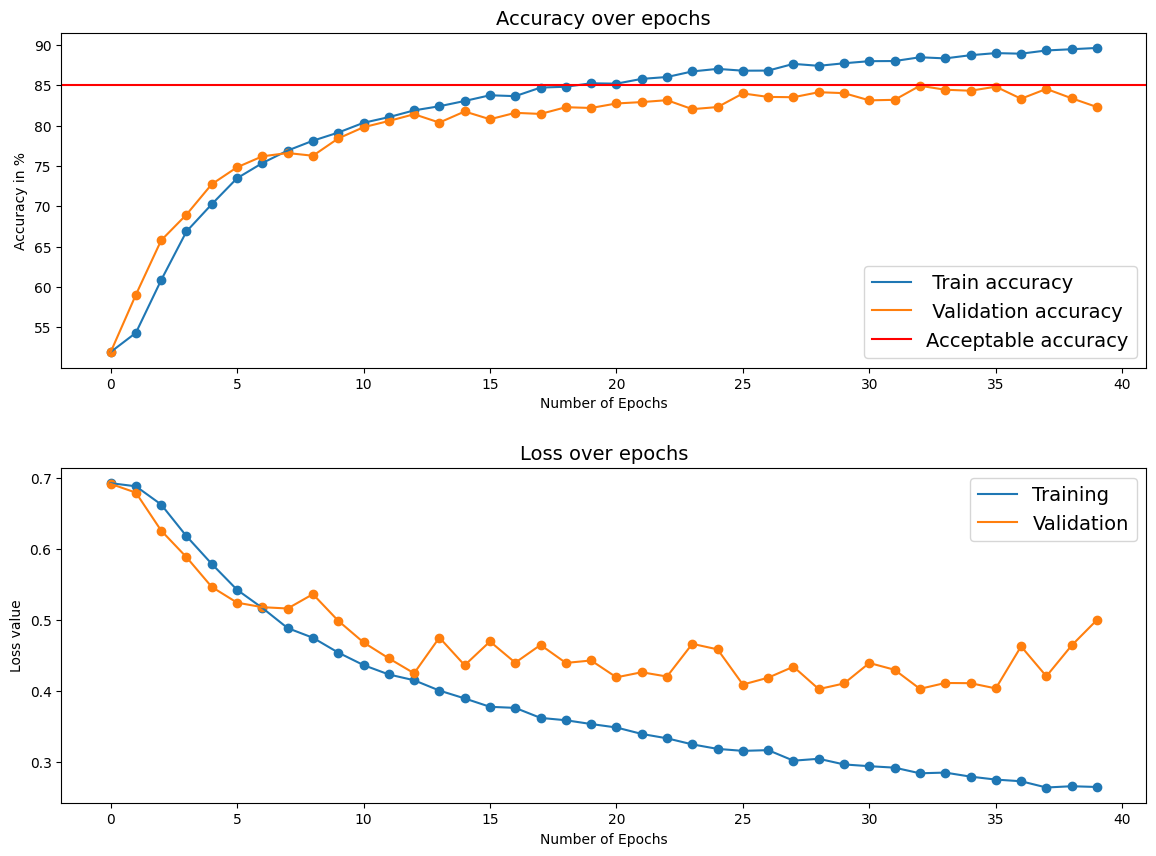

In [10]:
def main(model):
    ### START CODE HERE ### (approx. 6 lines)
    lr = 0.0004
    device = 'cuda'
    batch_size = 256
    epochs = 40
    model = model.to(device)
    train_dataloader, val_dataloader = get_data_loader(batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dict_log = train(model, optimizer, epochs, train_dataloader, val_dataloader, device)
    ### END CODE HERE ###
    plt.figure(figsize=(14,10))
    plot_stats(dict_log, baseline=85)
    return dict_log

### START CODE HERE ### (approx. 2 lines)
# define the transformer model
best_hp = {"d_model":32, "maxlen":5000,
            "vocab_size":vocab_size, "blocks":2, "num_heads":8,
            "drop":0.3, "attn_drop":0.1}
model = Transformer(**best_hp)
### END CODE HERE ###
dict_log = main(model)

### Expected result

![im1](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a11-12_transformer/figs/output_task6.png)

# Part VII. Positional embeddings instead of sine positional encodings

**Task:** Replace the sine positional encodings with positional embeddings. Encoding refers to a hard-coded transformation of the input, embedding to a learned one. For each position in the sequence, we use one trainable embedding vector. All you need to do here is to overwrite a small part of the `PositionalEncoding` class.

In [11]:
class PositionalEmbedding(PositionalEncoding):
    def __init__(self, d_model: int, dropout=0.1, max_len=5000):
        ### START CODE HERE ### (approx. 2 lines)
        super().__init__(d_model, dropout, max_len)
        self.pe = torch.nn.Parameter(torch.randn(1, max_len, d_model))
        ### END CODE HERE ###

def test_PE():
    PE = PositionalEmbedding(d_model=32, max_len=10000)
    a = torch.rand(16,100,32)
    print(PE(a).shape)

# Part VIII. Retrain with positional embeddings.

**Task:** Define the previous transformer with pos. embeddings and train it. For comparability, both models need to be trained with the same hyperparameters except positional embeddings.

Init Accuracy of the model: Train:48.676 	 Val:48.787998


Ep 39/40: Accuracy : Train:88.88 	 Val:85.39 || Loss: Train 0.275 	 Val 0.383: 100%|██████████| 40/40 [15:57<00:00, 23.93s/it]


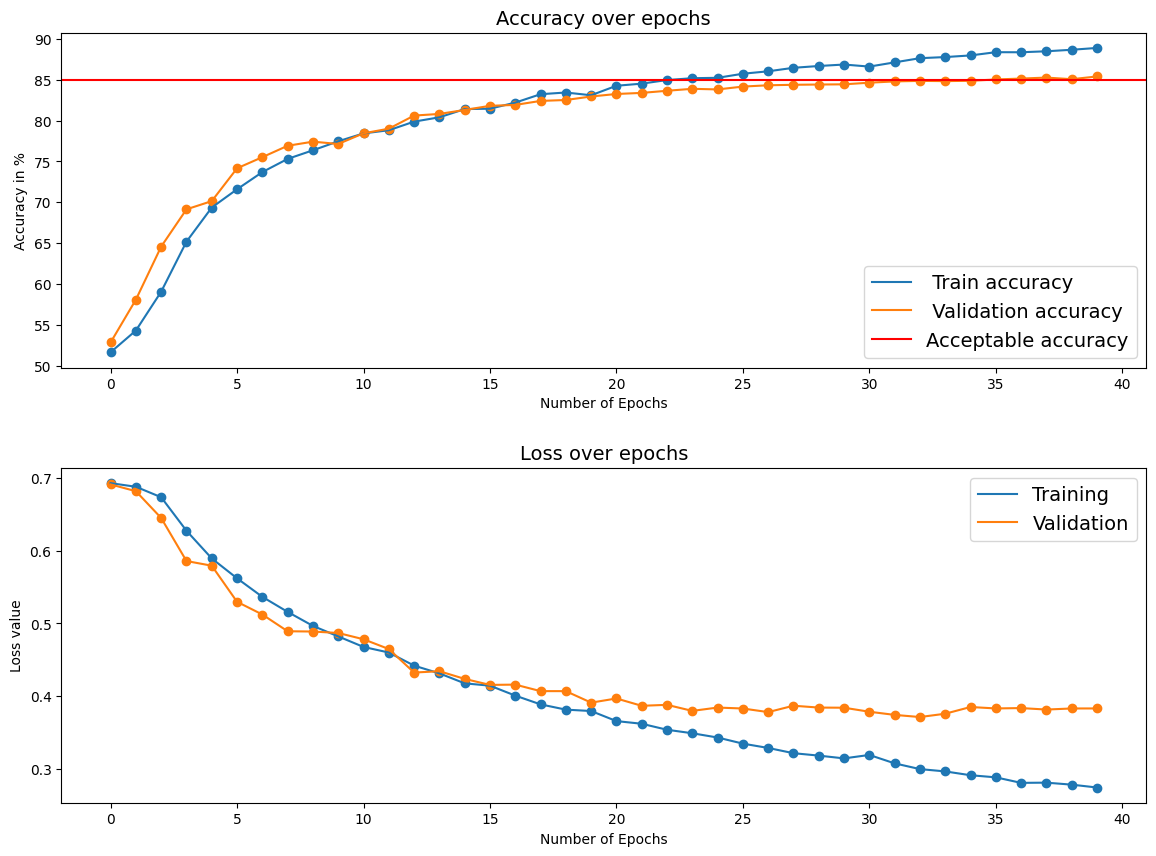

In [12]:
### START CODE HERE ### (approx. 6 lines)
class TransformerPE(Transformer):
    def __init__(self, d_model, maxlen, vocab_size, blocks, num_heads=2,  mlp_ratio=4., drop=0., attn_drop=0., classes=2):
        super(TransformerPE, self).__init__(d_model, maxlen, vocab_size, blocks, num_heads,  mlp_ratio, drop, attn_drop, classes)
        self.pos_enc = PositionalEmbedding(d_model=d_model, dropout=drop, max_len=maxlen)

model = TransformerPE(**best_hp)
dict_log = main(model)
### END CODE HERE ###

### Expected result

![im1](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a11-12_transformer/figs/output_task8.png)

# Bonus reads

That's the end of the last exercise of the Deep learning Course. If you reached this point, congratulations!

Endless research has been conducted on tranformers, positional embeddings, etc., especially in the computer vision area.
If you are interested to delve into this topic further, here are some links:

- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [How Transformers work in deep learning and NLP: an intuitive introduction by Nikolas Adaloglou](https://theaisummer.com/transformer/)
- [Relative Positional Encoding](https://jaketae.github.io/study/relative-positional-encoding/)
- [Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
- [Transformers from Scratch](https://e2eml.school/transformers.html)
- [Vision Transformer](https://paperswithcode.com/method/vision-transformer)
- [An Image is Worth 16x16 Words, What is a Video Worth?](https://arxiv.org/abs/2103.13915)
- [Demystifying efficient self-attention](https://towardsdatascience.com/demystifying-efficient-self-attention-b3de61b9b0fb)
- [Why multi-head self attention works: math, intuitions and 10+1 hidden insights by Nikolas Adaloglou](https://theaisummer.com/self-attention/)
